<a href="https://colab.research.google.com/github/secutron/ShowTime/blob/master/EDA_steel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect with Google Drive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Directory

In [0]:
import os
os.chdir('/content/drive/My Drive/dataset/Steel/steel1/')

In [0]:
#!ls ./test_images/

## Import required packages

In [31]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# from tensorflow.keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.inception_v3 import InceptionV3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Hyperparameters

원영상 크기는 1600x256x24b

In [0]:
image_size = 256
IMG_HEIGHT = 400
IMG_WIDTH = 1600
epochs = 10
batch_size = 4
model_name = 'Training Segementaion Unet 09-10-19.h5'

## Read csv for traning and validation 

In [33]:
tr = pd.read_csv('train.csv')
tr.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [34]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


defaultdict(int, {})

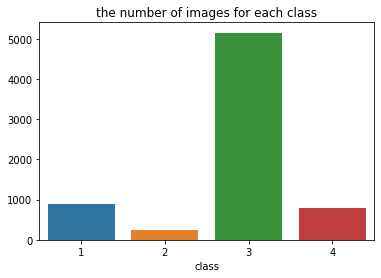

In [36]:
class_count = defaultdict(int)

for row in range(0, len(tr)):
  labels = tr.iloc[row, 1]
  class_count[labels] += 1;

fig, ax = plt.subplots()
sns.barplot(x=list(class_count.keys()), y=list(class_count.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
class_dict


ValueError: ignored

In [0]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
df_train.head()

#df_val = te[te['EncodedPixels'].notnull()].reset_index(drop=True)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


## Runlength encoding for masking

In [0]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

## Data Generator Train

In [0]:
def keras_generator_train(batch_size):
    while True:
        x_batch = []
        img_cls_list = []
        mask_list = []
        classification_list = []
        
        for i in range(batch_size):            
            fn = df_train['ImageId_ClassId'].iloc[i].split('_')[0]
            img = cv2.imread('dataset/train_images/'+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

            # print("Shape: ", img.shape)          
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            
            # img = cv2.resize(img, (image_size, image_size))
            # mask = cv2.resize(mask, (image_size, image_size))

            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
            mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))

            
            # img_cls = df_train['ImageId_ClassId'].iloc[i].split('_')[1]
            # if img_cls == '1':
            #     img_cls_list = np.array([1, 0, 0, 0])
            # elif img_cls == '2':
            #     img_cls_list = np.array([0, 1, 0, 0])
            # elif img_cls == '3':
            #     img_cls_list = np.array([0, 0, 1, 0])
            # else:
            #     img_cls_list = np.array([0, 0, 0, 1])



            x_batch.append(img)
            mask_list.append(mask)
            # classification_list.append(img_cls_list)
        
        y_batch = {'seg': np.array(mask_list),
                #    'cls': np.array(classification_list)
                }
           
        x_batch = np.array(x_batch)

        yield x_batch, y_batch

## Data Generator Valid

In [0]:
def keras_generator_valid(batch_size):
    while True:
        x_batch = []
        img_cls_list = []
        mask_list = []
        classification_list = []
        
        for i in range(batch_size):            
            fn = df_val['ImageId_ClassId'].iloc[i].split('_')[0]
            img = cv2.imread( 'dataset/valid_images/'+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            
            # img = cv2.resize(img, (image_size, image_size))
            # mask = cv2.resize(mask, (image_size, image_size))

            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

            mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
            
            # img_cls = df_train['ImageId_ClassId'].iloc[i].split('_')[1]
            # if img_cls == '1':
            #     img_cls_list = np.array([1, 0, 0, 0])
            # elif img_cls == '2':
            #     img_cls_list = np.array([0, 1, 0, 0])
            # elif img_cls == '3':
            #     img_cls_list = np.array([0, 0, 1, 0])
            # else:
            #     img_cls_list = np.array([0, 0, 0, 1])
            
            x_batch.append(img)
            mask_list.append(mask)
            # classification_list.append(img_cls_list)
        
        y_batch = {'seg': np.array(mask_list),
                #    'cls': np.array(classification_list)
                }
           
        x_batch = np.array(x_batch)
        
        yield x_batch, y_batch

In [0]:
for xcls, ycls in keras_generator_train(5):
    break
    
print(xcls.shape)
print(ycls['seg'].shape)
# print(ycls['cls'].shape)

(5, 400, 1600, 3)
(5, 400, 1600, 1)


In [0]:
for xcls, ycls in keras_generator_valid(5):
    break
    
print(xcls.shape)
print(ycls['seg'].shape)
# print(ycls['cls'].shape)

(5, 400, 1600, 3)
(5, 400, 1600, 1)


## Model

In [0]:
# in1 = Input(shape=(image_size, image_size, 3 ))

in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(in1)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
segmentation = Conv2D(1, (1, 1), activation='sigmoid', name='seg')(conv5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model = Model(inputs=[in1], outputs=[segmentation])

## Parameters for compilation of model

In [0]:
losses = {'seg': 'binary_crossentropy'
            }

metrics = {'seg': ['acc']
            }

# cls_w = {'seg': {0: 1.0, 
#                  1: 1.5647207819029325, 
#                  2: 1.0, 
#                  3: 1.0}
#         }

moni = {'seg': ['val_loss']
        }

## Compile

In [0]:
model.compile(optimizer="adam", loss = losses, metrics=metrics)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Fit Generator

In [0]:
%%time

modelcheckpoint = ModelCheckpoint(model_name,
                                  monitor='acc',
                                  mode='auto',
                                  verbose=1,
                                  save_best_only=True)

lr_callback = ReduceLROnPlateau(min_lr=0.000001)

callback_list = [modelcheckpoint, lr_callback]

history = model.fit_generator(
    keras_generator_train(batch_size),
    validation_data = keras_generator_valid(batch_size),
    validation_steps = 100,
    steps_per_epoch=100,
    epochs=epochs,
    verbose=1, 
    shuffle=True,
    callbacks = callback_list,
    # class_weight = cls_w,
)

Epoch 1/10
100/100 [==============================] - 43s 430ms/step - loss: 0.2712 - acc: 0.9467

Epoch 00001: acc improved from -inf to 0.94634, saving model to Training Segementaion Unet 09-10-19.h5
100/100 [==============================] - 176s 2s/step - loss: 0.2031 - acc: 0.9463 - val_loss: 0.2712 - val_acc: 0.9467
Epoch 2/10
100/100 [==============================] - 43s 430ms/step - loss: 0.2828 - acc: 0.9445

Epoch 00002: acc improved from 0.94634 to 0.94695, saving model to Training Segementaion Unet 09-10-19.h5
100/100 [==============================] - 176s 2s/step - loss: 0.1912 - acc: 0.9469 - val_loss: 0.2828 - val_acc: 0.9445
Epoch 3/10
100/100 [==============================] - 43s 430ms/step - loss: 0.3188 - acc: 0.9394

Epoch 00003: acc improved from 0.94695 to 0.94713, saving model to Training Segementaion Unet 09-10-19.h5
100/100 [==============================] - 176s 2s/step - loss: 0.1564 - acc: 0.9471 - val_loss: 0.3188 - val_acc: 0.9394
Epoch 4/10
100/100 [==